# 4. (a) Random Forests Algorithm from Scratch

### Importing all the necessary libraries

In [1]:
#importing all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from pprint import pprint
import statistics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,plot_confusion_matrix,accuracy_score
import time

import warnings
warnings.filterwarnings("ignore")

### Loading the data

In [2]:
df=pd.read_csv('https://web.stanford.edu/~hastie/ElemStatLearn//datasets/spam.data',sep=" ",header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


### Old Decision Tree code that we will be reusing in the Random Forests Implementation

In [3]:
def purity_check(data):
    
    return len(np.unique(data[:, -1])) == 1

def get_class(data):
    
    uni_class, counts_uni_class = np.unique(data[:, -1], return_counts=True) #returns the unique classes as well as their counts
    if(len(counts_uni_class)) == 0:
        return 0
    else:
        return uni_class[counts_uni_class.argmax()] #returns the class with majority count

def get_potential_splits(data,max_features):
    
    pot_spl = dict()
    rows , cols = data.shape
    
    col_indices = list(range(cols - 1)) # excluding the last column as it as label
    random_cols = random.sample(population=col_indices, k=max_features)
    for ind in random_cols:          
        pot_spl[ind] = np.unique(data[:, ind])
    
    return pot_spl #returns the potential splits

def split(data, col, val):
    #splits the data on the basis of particular column and value
    left_split = data[data[:, col] <= val] #data with values less 
    right_split = data[data[:, col] >  val] #data with values more
    
    return left_split, right_split


def calc_entropy(data):
    
    classes , counts = np.unique(data[:, -1], return_counts=True)
    prob = counts / counts.sum() #calc prob for each of the unique classes
    entropy = sum(prob * -np.log2(prob)) #entropy calc formula
     
    return entropy

def calculate_info_gain_entropy(left_split, right_split ,uncertainity):
    
    total=len(left_split) + len(right_split) #total number of records
    #calc prob for the splits
    prob_left = len(left_split) / total
    prob_right = len(right_split) / total

    return uncertainity -  (prob_left * calc_entropy(left_split) + prob_right * calc_entropy(right_split))

def find_best_split(data, pot_spl):
    
    uncertainity=calc_entropy(data)
    best_col=0
    best_val=0
        
    overall_info_gain = 0
    for col in pot_spl:
        for val in pot_spl[col]:
            left_split, right_split = split(data, col, val)
            current_info_gain = calculate_info_gain_entropy(left_split, right_split, uncertainity)

            if current_info_gain > overall_info_gain:
                overall_info_gain = current_info_gain
                best_col = col
                best_val = val
    
    return best_col, best_val

column_names = df.columns

def decision_tree_algorithm(df, count=0, threshold=2, max_depth=20,max_features=None):
    
    data = df
    if count == 0:
        data = df.values         
    
    # base case
    if (purity_check(data) | (len(data) < threshold) | (count == max_depth)): #if data is pure, threshold is reached or max_depth reached
        return get_class(data)
  
    count += 1 #incrementing the counter
    
    #determining the left and right split using the best split possible
    pot_spl = get_potential_splits(data,max_features)
    col, val = find_best_split(data, pot_spl)
    left_split, right_split = split(data, col, val)
        
        # check for empty splits
    if len(left_split) == len(right_split) == 0:
        return get_class(data)
        
        # determine the question
    attribute = column_names[col]
    ques = f'{attribute} <= {val}'
        
        # recursive calls
    success = decision_tree_algorithm(left_split,count, threshold, max_depth,max_features)
    failure = decision_tree_algorithm(right_split,count, threshold, max_depth,max_features)
    
     # subtree structure
    node = {ques: []}
    
    if success == failure:
        node = failure
    else:
        node[ques].append(success)
        node[ques].append(failure)
        
    return node


def classification(eg, tree):
    
    if not isinstance(tree, dict):
        return tree
    
    ques = list(tree.keys())[0]
    attribute , comparison_operator, val = ques.split()

    if eg[int(attribute)] <= float(val):
        res = tree[ques][0]
    else:
        res = tree[ques][1]

    return classification(eg, res)

### Code for the Random Forests Implementation

In [4]:
def perform_bootstrap(train_df,size):
    
    return train_df.iloc[np.random.randint(0,len(train_df),round(size * len(train_df)))]

def random_forest_algo(train_df,num_trees,bootstrap,max_feat,depth):
    forest = []
    for x in range(num_trees):
        boot_data = perform_bootstrap(train_df,bootstrap)
        tree = decision_tree_algorithm(boot_data, max_depth=depth, max_features=max_feat)
        forest.append(tree)
    return forest

def calculate_oob_scores(train_df,n_trees,nbootstrap,max_features,max_depth):
    oob_scores = []
    for x in range(n_trees):
        left_over = set()
        boot_data = perform_bootstrap(train_df,nbootstrap)
        left_over = set(train_df.index.tolist()) - set(boot_data.index.tolist())
        left_over = list(left_over)
        
        forest = random_forest_algo(boot_data,num_trees=n_trees,bootstrap=nbootstrap,max_feat=max_features,depth=max_depth)
        pred = rf_predictions(train_df.loc[left_over].drop(57,axis=1),forest)
        acc = rf_calculate_accuracy(train_df.loc[left_over],pred)
        oob_scores.append(acc)
        
    return oob_scores

def rf_predictions(test_df,forest):
    
    prediction = []
    for rows in range(len(test_df)):
        classify = []
        for trees in range(len(forest)):
            classify.append(classification(test_df.iloc[rows],forest[trees]))
        prediction.append(statistics.mode(classify))
    
    return prediction

def rf_calculate_accuracy(test_df, pred):

    test_df["predictions"] = pred
    test_df["comparison"] = test_df["predictions"] == test_df[57]
    
    return test_df["comparison"].mean()

### Train Test Split using Sklearn

In [5]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=101)

### Using GridSearchCV to decide upon the optimal parameters for the Random Forests Algorithm

In [6]:
#code for grid searchCV which I used to decide upon the opimal parameters for the random forests algorithm
#Please do not run this code as I took almost 6 hrs on my system 

# start_time = time.time()
# from sklearn.model_selection import GridSearchCV

# rfc = RandomForestClassifier()

# n_estimators = [int(x) for x in range(10,101,10)]
# max_features = ['sqrt','log2',5,10,15,20,25,30,35,40,45,50,55]
# max_depth = [None,5,10,15,20]
# min_samples_split = [2, 3, 5]
# bootstrap = [True, False]
# max_samples = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

# param_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'max_samples': max_samples,
#                'bootstrap': bootstrap}

# grid_model = GridSearchCV(estimator = rfc, param_grid = param_grid, cv = 2,verbose = 2)

# grid_model.fit(X_train,y_train)
# grid_model.best_params_

# end_time=time.time()
# print("Time Taken: {}".format(round(end_time-start_time,3)))

### Checking the Test Accuracy and Time Taken(secs) of our Random Forests Implementation

In [7]:
#Took about 5 mins to run on my system
start_time = time.time()

forest = random_forest_algo(train_df,num_trees=100,bootstrap=0.80,max_feat=5,depth=20)
pred = rf_predictions(test_df.drop(57,axis=1),forest)
acc = rf_calculate_accuracy(test_df,pred)*100

end_time=time.time()

print("Test Accuracy: {} %".format(acc))
print("Time Taken: {} secs".format(round(end_time-start_time,3)))

Test Accuracy: 94.5691527878349 %
Time Taken: 379.75 secs


### Checking Test Accuracy using Sklearn's RandomForestClassifier

In [8]:
X = df.drop(57,axis=1)
y = df[57]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

start_time = time.time()

rfc = RandomForestClassifier(n_estimators=100,max_features=5,max_depth=20,bootstrap=False,
                             max_samples=0.8,criterion='entropy',min_samples_split=3)
rfc.fit(X_train,y_train)
preds=rfc.predict(X_test)
acc = accuracy_score(preds,y_test)*100

end_time=time.time()

print("Test Accuracy: {} %".format(acc))
print("Time Taken: {} secs".format(round(end_time-start_time,3)))

Test Accuracy: 95.1484431571325 %
Time Taken: 1.0 secs


# 5. (b) Sensitivity of Random Forests to the parameter m (Our Implementation of Random Forests)

### Here due to Computation Infeasibility we are limiting the number of trees and depth to 10 (on full depth and 100 trees it takes hours to plot the behaviour) but that doesn't affect the sensitivity of Random Forests but accuracy of the model does get affected

Time Taken: 890.746 secs


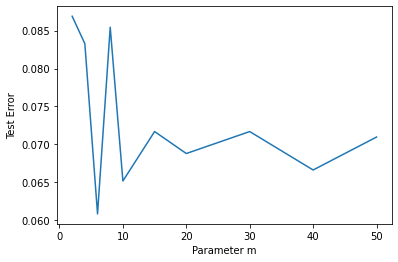

In [9]:
#Took about 15 mins to run on my system

start_time = time.time()
errors=[]
range_m = [2,4,6,8,10,15,20,30,40,50]

for m in range_m:
    forest = random_forest_algo(train_df,num_trees=10,bootstrap=0.80,max_feat=m,depth=10)
    pred = rf_predictions(test_df.drop(57,axis=1),forest)
    errors.append(1-rf_calculate_accuracy(test_df,pred))

end_time=time.time()
print("Time Taken: {} secs".format(round(end_time-start_time,3)))

plt.plot(range_m,errors)
plt.xlabel('Parameter m')
plt.ylabel('Test Error')
plt.show()

In [10]:
test_error = errors
test_error = [100*x for x in test_error]
sensitivity = pd.DataFrame(index = range_m,data = test_error, columns = ['Test Error'])
modified = sensitivity.reset_index()
modified.columns = ['Number of Features','Test Error(%)']
modified

,Number of Features,Test Error(%)
0,2,8.689356
1,4,8.327299
2,6,6.082549
3,8,8.544533
4,10,6.517017
5,15,7.168718
6,20,6.879073
7,30,7.168718
8,40,6.661839
9,50,7.096307


# Sensitivity of Random Forests to the parameter m (Sklearn's RandomForestClassifier)

Time Taken: 1.525 secs


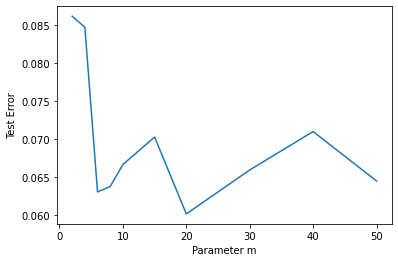

In [11]:
start_time = time.time()
errors=[]
range_m = [2,4,6,8,10,15,20,30,40,50]

for m in range_m:
    rfc=RandomForestClassifier(n_estimators=10,max_features=m,max_depth=10,bootstrap=True,max_samples=0.8,criterion='entropy')
    rfc.fit(X_train,y_train)
    pred = rfc.predict(X_test)
    errors.append(1-accuracy_score(y_test,pred))

end_time=time.time()
print("Time Taken: {} secs".format(round(end_time-start_time,3)))

plt.plot(range_m,errors)
plt.xlabel('Parameter m')
plt.ylabel('Test Error')
plt.show()

In [12]:
test_error = errors
test_error = [100*x for x in test_error]
sensitivity = pd.DataFrame(index = range_m,data = test_error, columns = ['Test Error'])
modified = sensitivity.reset_index()
modified.columns = ['Number of Features','Test Error(%)']
modified

,Number of Features,Test Error(%)
0,2,8.616944
1,4,8.472122
2,6,6.299783
3,8,6.372194
4,10,6.661839
5,15,7.023896
6,20,6.010138
7,30,6.589428
8,40,7.096307
9,50,6.444605


# 5. (c) Plot the OOB (out-of-bag) error and the Test Error against m (Our Implementation of Random Forests and OOB function) 

### Here due to Computation Infeasibility we are limiting the number of trees and depth to 5 (on full depth and 100 trees it takes hours to plot the behaviour) but that doesn't affect the sensitivity of Random Forests but accuracy of the model does get affected

Time Taken: 1314.423 secs


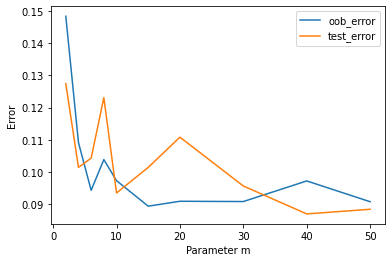

In [15]:
#Took about 38.5 mins to run on my system

start_time = time.time()
oob_errors=[]
test_errors=[]
range_m = [2,4,6,8,10,15,20,30,40,50]

for m in range_m:
    forest = random_forest_algo(train_df,num_trees=5,bootstrap=0.80,max_feat=m,depth=5)
    pred = rf_predictions(test_df.drop(57,axis=1),forest)
    test_errors.append(1-rf_calculate_accuracy(test_df,pred))
    oob_scores = calculate_oob_scores(train_df,n_trees=5,nbootstrap=0.8,max_features=m,max_depth=5)
    oob_error = 1 - np.mean(oob_scores)
    oob_errors.append(oob_error)
    
end_time=time.time()
print("Time Taken: {} secs".format(round(end_time-start_time,3)))


plt.plot(range_m,oob_errors,label='oob_error')
plt.plot(range_m,test_errors,label='test_error')
plt.xlabel('Parameter m')
plt.ylabel('Error')
plt.legend()
plt.show()

# Plot the OOB (out-of-bag) error and the Test Error against m (Sklearn's RandomForestClassifier and OOB function)

Time Taken: 0.702 secs


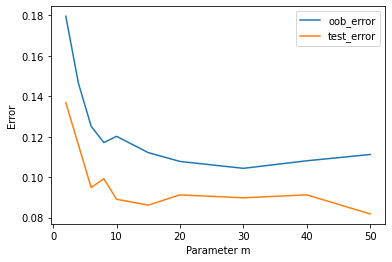

In [16]:
start_time = time.time()
oob_error=[]
test_error=[]
range_m = [2,4,6,8,10,15,20,30,40,50]

for m in range_m:
    rfc=RandomForestClassifier(n_estimators=5,max_features=m,max_depth=5,bootstrap=True,
                               max_samples=0.8,oob_score=True,criterion='entropy')
    rfc.fit(X_train,y_train)
    pred = rfc.predict(X_test)
    oob_error.append(1-rfc.oob_score_)
    test_error.append(1-accuracy_score(y_test,pred))

end_time=time.time()
print("Time Taken: {} secs".format(round(end_time-start_time,3)))

plt.plot(range_m,oob_error,label='oob_error')
plt.plot(range_m,test_error,label='test_error')
plt.xlabel('Parameter m')
plt.ylabel('Error')
plt.legend()
plt.show()